In [21]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

In [22]:
class Embedding:
    def __init__(self):
        self.name = "Base Embedding"

    def fit(self, tweets):
        pass

    def encode(self, tweets, name=""):
        return tweets

    def __repr__(self):
        return f"{self.name}"


class BagOfWords(Embedding):
    def __init__(self, max_features=5000):
        super().__init__()
        self.name = f"Bag of Words ({max_features})"
        self.vectorizer = CountVectorizer(max_features=max_features)

    def fit(self, tweets):
        self.vectorizer.fit(tweets)

    def encode(self, tweets, name=""):
        return self.vectorizer.transform(tweets)


class RobertaBaseSentimentEmbedding(Embedding):
    def __init__(self, load_embeddings=False):
        super().__init__()
        self.name = "Roberta Base Sentiment"
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", torch_dtype=torch.float16).to(self.device)
        # self.model.save_pretrained("./models/")
        self.load_embeddings = load_embeddings
        self.embeddings_file = f"embeddings_{self.name.lower().replace(' ', '_')}.npy"

    def encode(self, tweets, name=""):
        if self.load_embeddings:
            try:
                return np.load(name + "_" + self.embeddings_file)
            except FileNotFoundError:
                print("Embeddings file not found. Making new embeddings instead.")

        return self.make_embeddings(tweets, name)

    def make_embeddings(self, tweets, name):
        embeddings = []
        with torch.no_grad():
            for text in tqdm(tweets, desc=f"Encoding {name}"):
                tokens = self.tokenizer(text, padding=True, return_tensors='pt').to(self.device)
                embedding = self.model(**tokens).last_hidden_state[:, 0, :].cpu().detach().numpy().astype(np.float32)
                embeddings.append(embedding)
        np.save(name + "_" + self.embeddings_file, np.vstack(embeddings))
        return np.vstack(embeddings)

In [23]:
class Model:
    def __init__(self):
        self.name = "Base Model"

    def train(self, features, labels):
        pass

    def predict(self, features):
        pass

    def __repr__(self):
        return f"{self.name}"


class RandomPredictor(Model):
    def __init__(self):
        super().__init__()
        self.name = "Random Predictor"

    def train(self, features, labels):
        super().train(features, labels)

    def predict(self, features):
        super().predict(features)
        return np.random.choice([1, -1], size=features.shape[0])


class LinearRegression(Model):
    def __init__(self):
        super().__init__()
        self.name = f"Linear Regression"
        self.model = linear_model.LinearRegression()

    def train(self, features, labels):
        super().train(features, labels)
        self.model.fit(features, labels)

    def predict(self, features):
        super().predict(features)
        y_pred = self.model.predict(features)
        y_pred[y_pred >= 0] = 1
        y_pred[y_pred < 0] = -1
        return y_pred


class LogisticRegression(LinearRegression):
    def __init__(self):
        super().__init__()
        self.name = f"Logistic Regression"
        self.model = linear_model.LogisticRegression(C=1e5, max_iter=10000)


class RidgeRegression(LinearRegression):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.name = f"Ridge Regression"
        self.alpha = alpha
        self.model = linear_model.Ridge(self.alpha, max_iter=10000)

    def __repr__(self):
        return f"{self.name} ({self.alpha})"


class LassoRegression(LinearRegression):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.name = f"Lasso Regression"
        self.alpha = alpha
        self.model = linear_model.Lasso(self.alpha, max_iter=10000)

    def __repr__(self):
        return f"{self.name} ({self.alpha})"


def choose_ridge_lasso_hyper_parameters(model_cls, features, labels, min_alpha_pow=-5, max_alpha_pow=5, fraction=0.9):
    split_idx = int(fraction * features.shape[0])

    best_accuracy = (1.0, 0.5)
    for alpha_pow in tqdm(range(min_alpha_pow, max_alpha_pow), desc=f"Choosing hyper parameter..."):
        alpha = 10 ** alpha_pow
        model = model_cls(alpha=alpha)
        model.train(features[:split_idx], labels[:split_idx])
        predicted = model.predict(features[split_idx:])
        accuracy = (predicted == labels[split_idx:]).mean()
        if accuracy > best_accuracy[-1]:
            best_accuracy = (model.alpha, accuracy)

    return model_cls(alpha=best_accuracy[0])

In [24]:
RANDOM_SEED = 42
DATA_FOLDER = "data/"
TRAIN_NEG_FILE = DATA_FOLDER + "train_neg_full.txt"
TRAIN_POS_FILE = DATA_FOLDER + "train_pos_full.txt"
MAX_DATA_SIZE = 200000
NUMBER_OF_STEPS = 20

In [25]:
def create_dataset(neg_tweets_file, pos_tweets_file):
    tweets = []
    labels = []
    with open(neg_tweets_file, "r", encoding="utf-8") as f:
        for line in f:
            tweets.append(line.rstrip())
            labels.append(-1)
    with open(pos_tweets_file, "r", encoding="utf-8") as f:
        for line in f:
            tweets.append(line.rstrip())
            labels.append(1)
    df = pd.DataFrame({"tweet": tweets, "label": labels})
    df = df.drop_duplicates(subset=["tweet", "label"])
    return df

def split_dataset(dataset, test_fraction, seed=RANDOM_SEED):
    shuffled_dataset = dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
    train_df, test_df = train_test_split(shuffled_dataset, test_size=test_fraction, random_state=seed)
    return train_df, test_df

def get_data(embedding):
    print("Preparing data...")
    dataset = create_dataset(TRAIN_NEG_FILE, TRAIN_POS_FILE)
    train_data, test_data = split_dataset(dataset, 0.1, seed=RANDOM_SEED)
    train_labels = train_data["label"].to_numpy()
    test_labels = test_data["label"].to_numpy()

    print("Getting embedding...")
    embedding.fit(train_data["tweet"].to_numpy())
    train_tweets = embedding.encode(train_data["tweet"].to_numpy(), "train_tweets")
    test_tweets = embedding.encode(test_data["tweet"].to_numpy(), "test_tweets")

    return train_tweets, train_labels, test_tweets, test_labels

In [26]:
def evaluate_accuracy(predicted, actual):
    assert predicted.shape == actual.shape
    return (predicted == actual).mean()

In [27]:
def make_learning_curves(model, train_tweets, train_labels, test_tweets, test_labels, title):
    training_size_max = MAX_DATA_SIZE
    step_size = int(MAX_DATA_SIZE / NUMBER_OF_STEPS)
    training_size_min = step_size
    dataset_sizes = np.arange(training_size_min, training_size_max, step_size)

    train_accuracy = []
    test_accuracy = []

    for train_size in tqdm(dataset_sizes, desc=f"Making learning curves..."):
        model.train(train_tweets[:train_size], train_labels[:train_size])
        train_pred = model.predict(train_tweets)
        test_pred = model.predict(test_tweets)
        train_accuracy.append(evaluate_accuracy(train_pred, train_labels))
        test_accuracy.append(evaluate_accuracy(test_pred, test_labels))

    plot_learning_curves(train_accuracy, test_accuracy, dataset_sizes, title)
    save_results(title, test_accuracy)


def save_results(folder_name, accuracy):
    filename = f"./cluster_model/results/{folder_name}/loss_eval_data.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    results = [[[None, a] for a in accuracy]]
    with open(filename, "w") as f:
        json.dump(results, f)


def plot_learning_curves(train_accuracy, test_accuracy, dataset_sizes, title):
    plt.figure()
    plt.plot(dataset_sizes, train_accuracy, 'r--', label="Training Accuracy")
    plt.plot(dataset_sizes, test_accuracy, 'b-', label="Test Accuracy")
    plt.ylim([0.4, 1])
    plt.yticks(np.arange(0.4, 1.1, 0.1))
    plt.grid(True)
    plt.xlabel("Dataset Size")
    plt.ylabel("Accuracy")
    plt.title(f"{title}")
    plt.legend()
    plt.show()

In [28]:
def evaluate_baseline(embedding, model):
    train_tweets, train_labels, test_tweets, test_labels = get_data(embedding)

    print(f"Training {model} with {embedding}...")
    make_learning_curves(model, train_tweets, train_labels, test_tweets, test_labels, title=f"{model} with {embedding}")
    return evaluate_accuracy(model.predict(test_tweets), test_labels)

Bag of Words baseline:
Preparing data...
Getting embedding...
Training Logistic Regression with Bag of Words (5000)...


Making learning curves...: 100%|██████████| 19/19 [04:10<00:00, 13.20s/it]


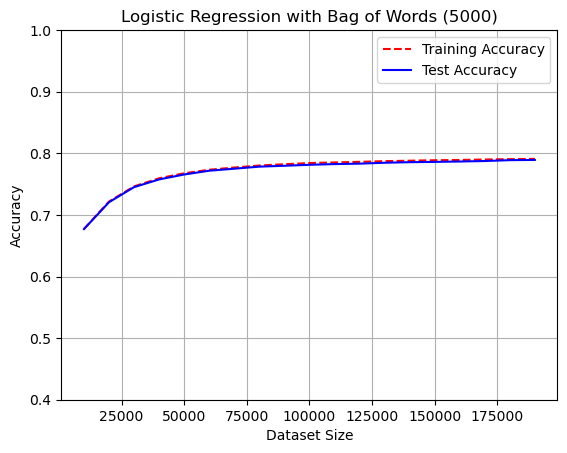

Final accuracy: 0.7892789662143413


In [29]:
np.random.seed(RANDOM_SEED)

print("Bag of Words baseline:")
embedding = BagOfWords()
model = LogisticRegression()
final_accuracy = evaluate_baseline(embedding, model)
print(f"Final accuracy: {final_accuracy}")

In [30]:
# print("Roberta baseline:")
# embedding = RobertaBaseSentimentEmbedding(load_embeddings=True)
# model = LogisticRegression()
# final_accuracy = evaluate_baseline(embedding, model)
# print(f"Final accuracy: {final_accuracy}")